<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap">
</head>

<body>

<div style="background-color: #65BF6F; color: black; text-align: center; padding: 10px; font-family: 'Roboto', sans-serif; font-size: 24px">
    

<div style="text-align:center;">
    <img src="Jaki_Charrua_gatodelespacio.jpg" alt="Drawing" style="width:150px; border-radius:90%;"/>
    
    
</div> 


<body>


    
</html>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link rel="stylesheet" href="https://use.typekit.net/your-typekit-id.css">
</head>
<body>
    
    
<div style="background-color: #000000; color: white; text-align: center; padding: 10px; font-family: 'Proxima Nova', sans-serif; font-size: 24px;">
    Replication Lab  <br>
    GEC0319 | Time Series <br>
    
    
</div>



    
    
</body>
</html>

## **Spurious Regressions in Econometrics** 
- Author(s): **CWJ Granger, P. Newbold**  
- First Published: **1973**
- Link: [here](https://drive.google.com/file/d/1VjqQ_9FVNBlJ3mahwDYN9X8cRa6fINKk/view?usp=drive_link)

#### Abstract

*This paper highlights a common occurrence in applied econometric literature where time series regression equations exhibit a high degree of fit, as indicated by the coefficient of multiple correlation (R2) or the corrected coefficient (R2), but simultaneously display a very low value for the Durbin-Watson statistic. This phenomenon, despite being warned against in econometric textbooks due to the dangers of autocorrelated errors, is still prevalent in well-regarded applied research. The authors provide examples of equations with remarkably high R2 values paired with exceptionally low Durbin-Watson statistics, suggesting that such cases may be spurious. They recount an experience illustrating how easily one can be led to produce a spurious model if not careful with the formulation of the autocorrelation structure of the errors in the regression equation. Consequently, the authors propose a more detailed investigation to ascertain any meaningful insights from regression equations exhibiting these properties.*

## 📚 Index

- [I. Section Title](#section-I)
- [II. Section Title](#section-II)
- [III. Section Title](#section-III)
- [IV. Section Title](#section-IV)


# section-I
---

### Librerías

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns

from scipy.stats import t as t_Student

plt.style.use('seaborn')
plt.rc('figure', figsize=(15,4))
plt.rc('axes', titlesize=20, labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [26]:
from joblib import Parallel, delayed

def Monte_Carlo(function, repetitions, columns, *args, **kwargs):
    """
    Executes Monte Carlo simulations in parallel, utilizing all processor cores.

    Arguments:
        function: a function that yields a single realization of the quantities to be simulated.
        repetitions: an integer indicating how many samples are desired to be simulated.
        columns: a list (or tuple) of strings, identifying the individual quantities returned by `function`.
        *args, **kwargs: other parameters required by `function`.

    Returns:
        A pandas DataFrame, with as many rows as `repetitions` and columns as strings in `columns`.
    """
    data = Parallel(n_jobs=1)(delayed(function)(*args, **kwargs) for _ in range(repetitions))
    return pd.DataFrame(data, columns=columns)

# section-II
---

### Regression of one random walk against another independent random walk

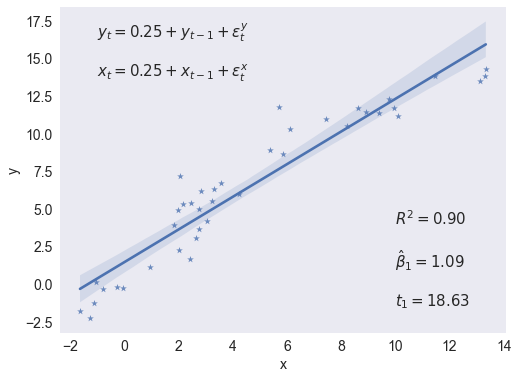

In [24]:
np.random.seed(240)
e = np.random.randn(2,40)
y, x = (0.25+e).cumsum(axis=1)
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()


fig, ax = plt.subplots(figsize=[8,6])
sns.regplot(x=x,y=y,marker='*',ax=ax)
ax.set(xlabel='x', ylabel='y')

statslabel = f'$R^2={res.rsquared:.2f}$'
statslabel += f'\n\n$\\hat\\beta_1={res.params[1]:.2f}$'
statslabel += f'\n\n$t_1={res.tvalues[1]:.2f}$'
ax.annotate(statslabel, (10,5), size=15, va='top')


modellabel = r'$y_t = 0.25 + y_{t-1} + \epsilon^y_t$'
modellabel += '\n\n$x_t = 0.25 + x_{t-1} + \\epsilon^x_t$'
ax.annotate(modellabel, (-1,17.5), size=15, va='top')

ax.grid(False)
fig.savefig('regresion-espuria-1caso.pdf', bbox_inches='tight')

In [10]:
res.params

array([1.44456189, 1.08570021])

In [11]:
np.linalg.solve(X.T @ X, X.T @ y)

array([1.44456189, 1.08570021])

# section-III
---

### "Monte Carlo Experiment to Determine the Distribution of the t-Statistic"

In [12]:
def regresion_estacionaria(T=100):
    y, x = np.random.randn(2,T)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [13]:
def regresion_espuria(T=100):
    e = np.random.randn(2,T)
    y, x = e.cumsum(axis=1)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [25]:
import logging

def Monte_Carlo(funcion, repeticiones, columnas, *args, **kwargs):
    logging.basicConfig(filename='montecarlo.log', level=logging.DEBUG)
    try:
        datos = Parallel(n_jobs=1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
        return pd.DataFrame(datos, columns=columnas)
    except Exception as e:
        logging.exception(f"Error in Monte_Carlo: {str(e)}")
        raise

In [21]:
%%time
N = 1000
np.random.seed(12345)
tvalues = Monte_Carlo(regresion_estacionaria, N,['t'])

np.random.seed(12345)
zvalues = Monte_Carlo(regresion_espuria, N, ['z'])

Wall time: 941 ms


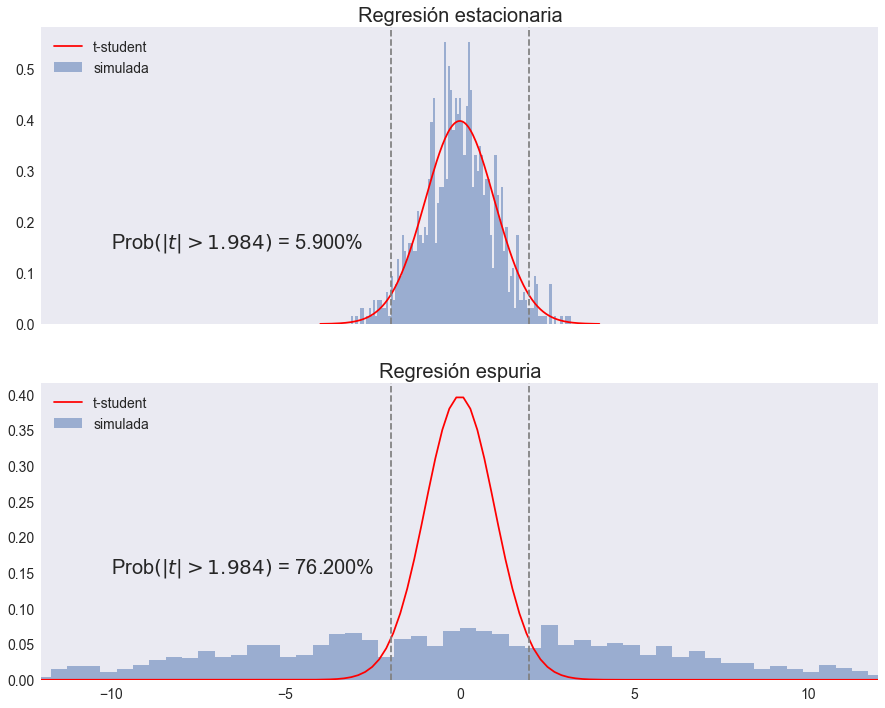

In [27]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=[15, 12], sharex=True)

maxtval = 12
t5crit = t_Student.isf(0.05/2, 98)


# regresión estacionaria
ff, edges = np.histogram(tvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax0.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-4,4, 200)
ax0.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax0.set(xlim=[-maxtval, maxtval], title='Regresión estacionaria')
ax0.legend(['t-student', 'simulada'], loc='upper left')


# regresión espuria
ff, edges = np.histogram(zvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax1.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-20, 20, 200)
ax1.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax1.set(xlim=[-maxtval,maxtval], title='Regresión espuria')
ax1.legend(['t-student', 'simulada'], loc='upper left')

# valores críticos
opciones = dict(ls="--", color='gray')
ax0.axvline(t5crit, **opciones)
ax0.axvline(-t5crit, **opciones)
ax1.axvline(t5crit, **opciones)
ax1.axvline(-t5crit, **opciones)

# error tipo I
err1 = (tvalues.abs() > t5crit).mean()*100
err1 = err1.iloc[0]
ax0.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1:.3f}%', (-10,0.15), size=20)

err1bad = (zvalues.abs() > t5crit).mean()*100
err1bad = err1bad.iloc[0]
ax1.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1bad:.3f}%', (-10,0.15), size=20)

ax0.grid(False)
ax1.grid(False)
fig.savefig('regresion-espuria.pdf', bbox_inches='tight')

# section-IV

---

Credits to [Prof. Romero](https://www.linkedin.com/in/randallromeroaguilar/)